In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row

In [7]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [8]:
lsbg_cat = Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')
lsbg_cat.sort('viz-id')

### The measurement is done by running `sbatch 1k_meas.slurm`, etc. Check `vanilla_measure_all.py` for details.

The measurement catalogs are saved at `./Catalog/NSA/z002_004/lsbg_measure_vaniila_XXXXX.fits`.

Below, we combine these catalogs together.

In [12]:
meas_cat_all = Table.read('./Catalog/NSA/z002_004/_lsbg_measure_vanilla_1k.fits')
meas_cat_all[1000:2000] = Table.read('./Catalog/NSA/z002_004/_lsbg_measure_vanilla_2k.fits')[1000:2000]
meas_cat_all[2000:3000] = Table.read('./Catalog/NSA/z002_004/_lsbg_measure_vanilla_3k.fits')[2000:3000]
meas_cat_all[3000:4000] = Table.read('./Catalog/NSA/z002_004/_lsbg_measure_vanilla_4k.fits')[3000:4000]
meas_cat_all[4000:] = Table.read('./Catalog/NSA/z002_004/_lsbg_measure_vanilla_5k.fits')[4000:]

In [13]:
meas_cat_all

ID,flux [4],mag [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11.0,1327.3345947265625 .. 3278.31787109375,19.192548751831055 .. 18.210872650146484,22.133670806884766 .. 21.151992797851562,23.659343719482422 .. 22.67766571044922,23.680051803588867 .. 22.698375701904297,69.41485346243077,67.5430857078083,68.67258455965919,67.91593418824468,0.0928122889018671,0.09453220744676005,-0.3671055463602985,-0.3692052807067361,14.5653958851347,15.3917378419479,7.49128193890762,14.548410130966964,23.071119873769437,0.4423498942987682,-1.6781474720724698,-0.6074118250748759,-0.12233610326229286,2.4425626670211247,0.2214827832077451,0.2861047477346293,0.0,0.029584633167884303,1.0528421885218506,15.866700487447256,0.05186480599470992,0.5991626275106965,67.99742891722117,68.00313900895152,0.5007696952947733,0.0,0.0
21.0,158.03076171875 .. 327.2117614746094,21.503145217895508 .. 20.712928771972656,23.915809631347656 .. 23.125591278076172,25.47779083251953 .. 24.687572479248047,25.467571258544922 .. 24.677352905273438,45.113397087851624,46.01939325544433,44.74999997966811,45.60677570982223,0.10100177986724101,0.1011422488574778,0.14603615063586742,0.15645668550306369,10.192022552932062,10.75575852466443,5.125914113795756,10.192022587745067,15.438223538286417,0.3839189305646859,-1.7152345292881712,-0.8709437649081022,-0.1853378583120168,2.394129999222052,0.21291779329144295,0.3014991442002375,0.0,0.05166314400916215,2.6119993718935617,34.1176565420939,0.22217153302565254,2.9228182814019887,44.96523153031157,45.48375258262997,0.020183846487009695,0.0,0.0
40.0,6.705384731292725 .. 27.551454544067383,24.933940887451172 .. 23.399639129638672,25.465961456298828 .. 23.931659698486328,26.4553165435791 .. 24.9210147857666,26.440441131591797 .. 24.906139373779297,15.025967636728224,14.717092481217042,14.94336993320487,14.369502492731986,0.19146260686248706,0.19508772032784494,1.3052788424280128,1.3060989288677118,3.6871523952096013,4.093013774000071,2.015020525973397,3.6677221379778655,6.049063059358922,0.45761633700514415,-1.6100521254591893,-0.5790330088813183,-0.09775707180373466,2.387043187326103,0.1541989640314017,0.2680009210710161,0.0,0.0,0.8212634874787028,2.651452427709472,0.512361235096146,1.4805723107006807,15.003523829725442,14.396926148529065,0.17240276864579834,0.0,0.0
64.0,2729.158447265625 .. 5420.36767578125,18.409927368164062 .. 17.664928436279297,22.737266540527344 .. 21.992265701293945,24.581674575805664 .. 23.836673736572266,24.49850845336914 .. 23.753507614135742,125.56082427491864,128.3331274388056,128.787533017265,127.09469580144878,0.39377024593891596,0.3971718559366364,-0.4857212037821779,-0.4835314751782506,30.019840185609056,36.44945141682886,14.196796375883643,30.016979507523732,47.8257088399383,0.5062319460747509,-1.6606008301694404,-0.30335549162256115,-0.05665388877954891,2.637355311266379,0.26786584549519743,0.40173389812692617,0.0,0.051709989120371946,1.4613695231005759,60.17010659857957,0.6486335415191594,2.5913002784086574,128.37600543738245,127.28569713110086,0.1952502699556463,0.0,0.0
102.0,1055.0723876953125 .. 2415.76123046875,19.441795349121094 .. 18.54236602783203,22.597370147705078 .. 21.697940826416016,24.002731323242188 .. 23.103302001953125,23.9881591796875 .. 23.088729858398438,75.6818744329894,74.15419477942925,75.10699478184354,74.75000004217492,0.14573773004583246,0.14383748358516668,0.5801291738245357,0.5777566576635865,14.262523215671392,15.275717324999748,7.26126630947331,14.26252

In [14]:
len(meas_cat_all[(~np.isnan(meas_cat_all['ID']))])

5576

In [15]:
meas_cat_all.write('./Catalog/NSA/z002_004/lsbg_measure_vanilla_all.fits', overwrite=True)

### Analysis

In [19]:
import kuaizi
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='nature', usetex=False)

In [20]:
meas_cat = Table.read('./Catalog/NSA/z002_004/lsbg_measure_vanilla_all.fits')

In [22]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

In [23]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [24]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 1276
Gal: 2404
Junk: 1896


In [25]:
#lsbg_cat[candy & mask]

(-0.5, 2.2)

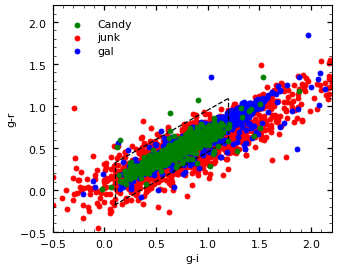

In [26]:
plt.scatter((g_mag - i_mag)[candy], (g_mag - r_mag)[candy], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk], (g_mag - r_mag)[junk], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal], (g_mag - r_mag)[gal], color='b', label='gal')

color_bound = [0.1, 1.2]
half_width = 0.25
plt.vlines(color_bound[0], 0.7 * color_bound[0] - half_width, 
           0.7 * color_bound[0] + half_width, color='k', ls='--')
plt.vlines(color_bound[1], 0.7 * color_bound[1] - half_width, 
           0.7 * color_bound[1] + half_width, color='k', ls='--')

x = np.linspace(color_bound[0], color_bound[1], 100)
plt.plot(x, 0.7 * x - half_width, color='k', ls='--')
plt.plot(x, 0.7 * x + half_width, color='k', ls='--')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

plt.xlim(-0.5, 2.2)
plt.ylim(-0.5, 2.2)

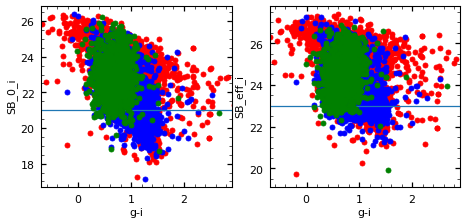

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

plt.sca(axes[0])
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_0'][:, 2][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_0'][:, 2][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_0'][:, 2][gal], color='b')
plt.xlabel('g-i')
plt.ylabel('SB_0_i')
plt.axhline(21.)
plt.xlim(-0.7, 2.9)

plt.sca(axes[1])
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_eff_ellip'][:, 1][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_eff_ellip'][:, 1][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_eff_ellip'][:, 1][gal], color='b')
plt.xlabel('g-i')
plt.ylabel('SB_eff_i')
plt.axhline(23.)
plt.xlim(-0.7, 2.9)

plt.subplots_adjust(wspace=0.2)

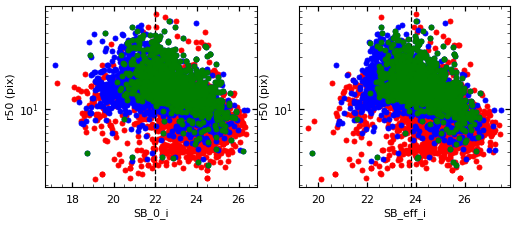

In [28]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax1)
plt.scatter(meas_cat['SB_0'][:, 2][candy ], meas_cat['rhalf_ellip'][candy ], color='g', zorder=10)
plt.scatter(meas_cat['SB_0'][:, 2][junk ], meas_cat['rhalf_ellip'][junk ], color='r')
plt.scatter(meas_cat['SB_0'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk ], color='b')

plt.axvline(22., color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_0_i')
plt.ylabel('r50 (pix)')

plt.sca(ax2)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy ], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk ], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk], color='b')

plt.axvline(23.8, color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50 (pix)')


plt.subplots_adjust(wspace=0.2)

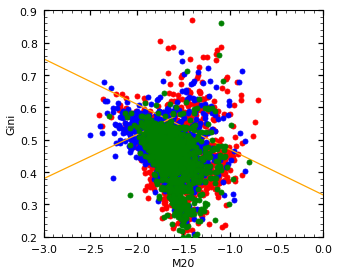

In [29]:
plt.scatter(meas_cat['M20'][candy], meas_cat['Gini'][candy], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk], meas_cat['Gini'][junk], color='r')
plt.scatter(meas_cat['M20'][gal], meas_cat['Gini'][gal], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'A')

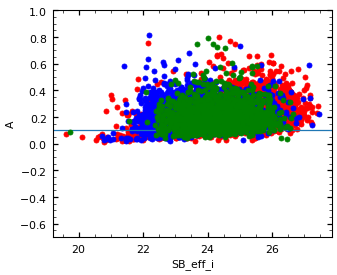

In [30]:
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][gal], meas_cat['A'][gal], color='b')
plt.ylim(-.7, 1)
#plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('SB_eff_i')
plt.ylabel('A')

Text(0, 0.5, 'A_max')

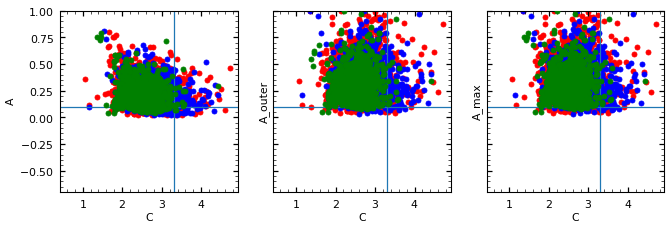

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

plt.sca(axes[0])
plt.scatter(meas_cat['C'][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A'][gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A')

plt.sca(axes[1])
plt.scatter(meas_cat['C'][candy], meas_cat['A_outer'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A_outer'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A_outer'][gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A_outer')

plt.sca(axes[2])
A_max = np.max([meas_cat['A_outer'], meas_cat['A']], axis=0)
plt.scatter(meas_cat['C'][candy], A_max[candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], A_max[junk], color='r')
plt.scatter(meas_cat['C'][gal], A_max[gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A_max')

Text(0, 0.5, 'r50')

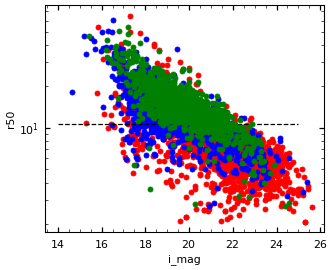

In [33]:
plt.scatter(i_mag[candy], meas_cat['r50'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['r50'][junk], color='r')
plt.scatter(i_mag[gal], meas_cat['r50'][gal], color='b')

#plt.ylim(0, 1)
plt.hlines(1.8 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

Text(0, 0.5, 'r50')

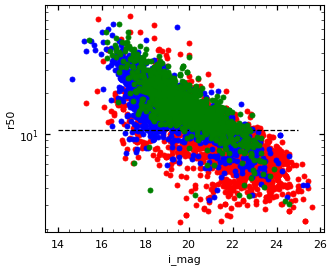

In [34]:
plt.scatter(i_mag[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(i_mag[gal], meas_cat['rhalf_ellip'][gal], color='b')

#plt.ylim(0, 1)
plt.hlines(1.8 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

(-0.6, 2.5)

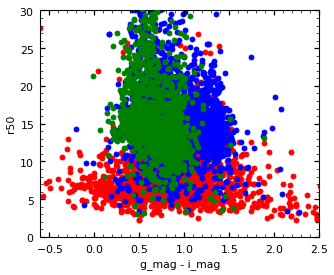

In [35]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')

plt.ylim(0, 30)
plt.xlim(-0.6, 2.5)

(0.0, 30.0)

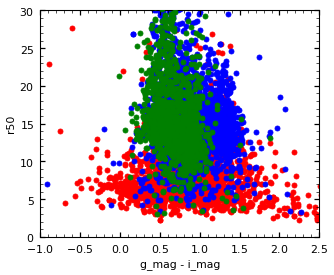

In [38]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')
plt.xlim(-1, 2.5)
plt.ylim(0, 30)

In [39]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 1276
Gal: 2404
Junk: 1896


In [62]:
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168) & (meas_cat['rhalf_ellip'] < 12 / 0.168)# & (meas_cat['r20'] > 1 / 0.168)
#mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168) & (meas_cat['rhalf_ellip'] < 12 / 0.168)

mask &= (meas_cat['SB_0'][:, 2] > 21)

#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.8) # Cuts based on JL votes
mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.) # Cuts based on JG votes

mask &= (meas_cat['ell_sym'] < 0.65)

mask &= (meas_cat['M20'] < -1.1)
mask &= (meas_cat['Gini'] < 0.7)
mask &= ~((meas_cat['M20'] < -1.6) & (
    meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))

mask &= (meas_cat['C'] < 3.5)
#mask &= (meas_cat['A_outer'] <= 0.13)


print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 959
Gal: 913
Junk: 121


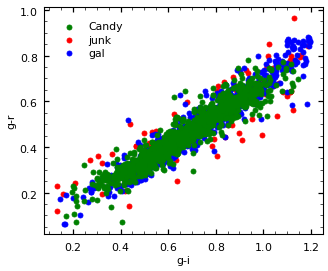

In [63]:
plt.scatter((g_mag - i_mag)[candy & mask], (g_mag - r_mag)[candy & mask], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk & mask], (g_mag - r_mag)[junk & mask], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal & mask], (g_mag - r_mag)[gal & mask], color='b', label='gal')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

#plt.xlim(-0.5, 2.2)
#plt.ylim(-0.5, 2.2)

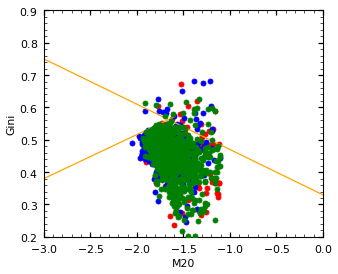

In [64]:
plt.scatter(meas_cat['M20'][candy & mask], meas_cat['Gini'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk & mask], meas_cat['Gini'][junk & mask], color='r')
plt.scatter(meas_cat['M20'][gal & mask], meas_cat['Gini'][gal & mask], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'r50')

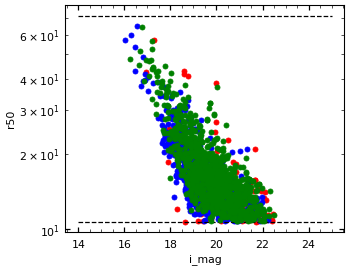

In [65]:
plt.scatter(i_mag[candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(i_mag[junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(i_mag[gal & mask], meas_cat['rhalf_ellip'][gal & mask], color='b')

#plt.ylim(0, 1)
plt.hlines(1.8 / 0.168, 14, 25, color='k', ls='--')
plt.hlines(12 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

Text(0, 0.5, 'r50')

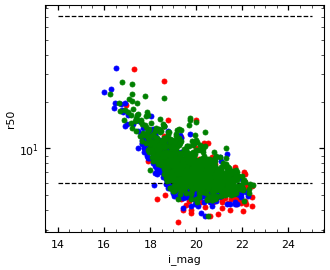

In [66]:
plt.scatter(i_mag[candy & mask], meas_cat['r20'][candy & mask], color='g', zorder=10)
plt.scatter(i_mag[junk & mask], meas_cat['r20'][junk & mask], color='r')
plt.scatter(i_mag[gal & mask], meas_cat['r20'][gal & mask], color='b')

#plt.ylim(0, 1)
plt.hlines(1 / 0.168, 14, 25, color='k', ls='--')
plt.hlines(12 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

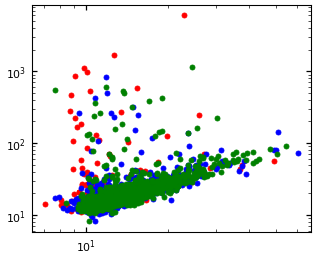

In [67]:
plt.scatter(meas_cat['r50'][candy & mask], meas_cat['sersic_rhalf'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['r50'][junk & mask], meas_cat['sersic_rhalf'][junk & mask], color='r',)
plt.scatter(meas_cat['r50'][gal & mask], meas_cat['sersic_rhalf'][gal & mask], color='b')
plt.xscale('log')
plt.yscale('log')

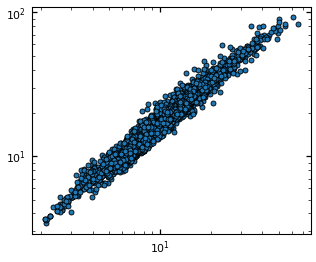

In [68]:
plt.scatter(meas_cat['r50'], meas_cat['r80'])
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'r50')

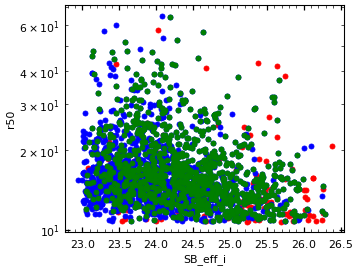

In [69]:
plt.scatter(meas_cat['SB_eff_circ'][:, 2][candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_circ'][:, 2][junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(meas_cat['SB_eff_circ'][:, 2][~junk & mask], meas_cat['rhalf_ellip'][~junk & mask], color='b')

#plt.ylim(0, 1)
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50')

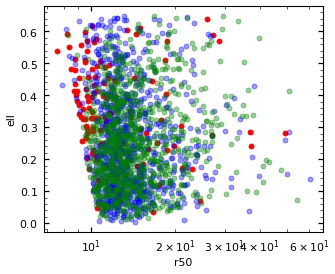

In [70]:
plt.scatter(meas_cat['rhalf_circ'][candy & mask], meas_cat['ell_sym'][candy & mask], color='g', zorder=10, alpha=.4)
plt.scatter(meas_cat['rhalf_circ'][junk & mask], meas_cat['ell_sym'][junk & mask], color='r')
plt.scatter(meas_cat['rhalf_circ'][gal & mask], meas_cat['ell_sym'][gal & mask], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('r50')
plt.ylabel('ell')
plt.xscale('log')
#plt.yscale('log')

### Save catalog

In [255]:
# lsbg_cat['host_RA'] = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004.fits')[100:]['host_RA']
# lsbg_cat['host_DEC'] = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004.fits')[100:]['host_DEC']

In [71]:
from astropy.table import hstack
hstack([lsbg_cat[mask], meas_cat[mask]]
      ).write('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004_after_cuts_JG.fits', overwrite=True)

In [72]:
cuts_cat = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004_after_cuts_JG.fits')

In [73]:
from astropy.coordinates import SkyCoord

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

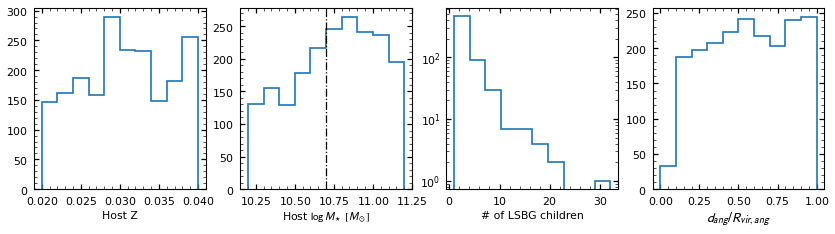

In [74]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2);
plt.xlabel('Host Z')

plt.sca(axes[1])
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2);
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(cuts_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')
host_coord = SkyCoord(cuts_cat['host_RA'], cuts_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / cuts_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=10, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

In [75]:
ang_diam_dist = cuts_cat['host_ang_diam_dist'] # not consider peculiar motion

rhalf_phys = cuts_cat['rhalf_circ'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_circ_phys'] = rhalf_phys

rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_ellip_phys'] = rhalf_phys

In [76]:
cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
log_ML_V = 1.493 * BV - 0.681
M = (4.83 - V_abs) / (2.5) + log_ML_V
cuts_cat['log_m_star'] = M

In [101]:
### UDGs
flag = (cuts_cat['rhalf_ellip_phys'] > 1.5) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
print('# of UDGs:', np.sum(flag))

# of UDGs: 112


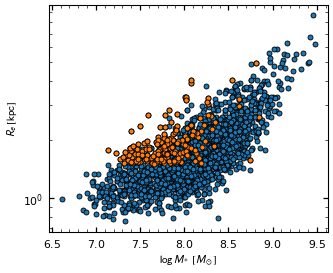

In [85]:
plt.scatter(cuts_cat['log_m_star'], cuts_cat['rhalf_ellip_phys'])
plt.scatter(cuts_cat['log_m_star'][flag], cuts_cat['rhalf_ellip_phys'][flag])

plt.xlabel(r'$\log\, M_*\ [M_\odot]$')
plt.ylabel(r'$R_e\ [\rm kpc]$')

plt.yscale('log')

Text(0, 0.5, '$SB_g$')

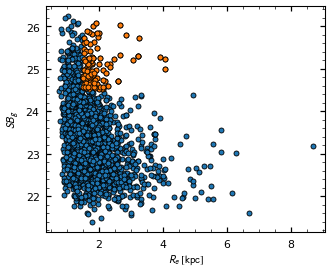

In [103]:
plt.scatter(cuts_cat['rhalf_ellip_phys'], cuts_cat['SB_0'][:, 0])
plt.scatter(cuts_cat['rhalf_ellip_phys'][flag], cuts_cat['SB_0'][:, 0][flag])
#plt.scatter(cuts_cat['log_m_star'][flag], cuts_cat['rhalf_ellip_phys'][flag])


plt.xlabel(r'$R_e\ [\rm kpc]$')
plt.ylabel(r'$SB_g$')

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

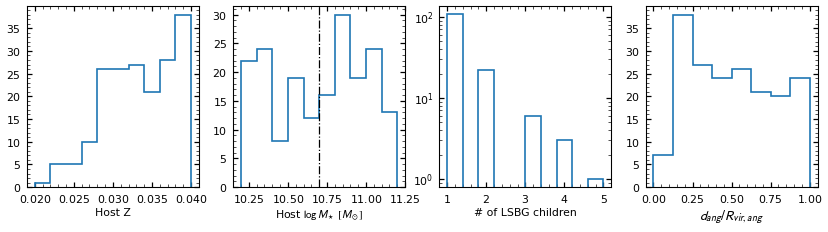

In [86]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(cuts_cat[flag]['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2);
plt.xlabel('Host Z')

plt.sca(axes[1])
plt.hist(cuts_cat[flag]['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2);
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(cuts_cat[flag]['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(cuts_cat[flag]['ra'], cuts_cat[flag]['dec'], unit='deg')
host_coord = SkyCoord(cuts_cat[flag]['host_RA'], cuts_cat[flag]['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / cuts_cat[flag]['host_r_vir_ang'].data, 
         range=[0, 1.], bins=8, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

(array([12., 82., 47., 24., 10.,  3.,  7.,  1.,  0.,  1.]),
 array([1.2931771 , 1.76884889, 2.24452068, 2.72019247, 3.19586426,
        3.67153605, 4.14720784, 4.62287963, 5.09855142, 5.57422321,
        6.049895  ]),
 <BarContainer object of 10 artists>)

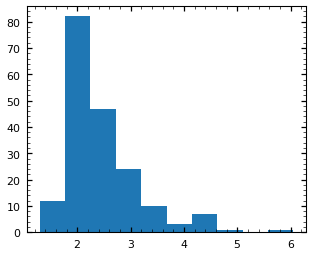

In [87]:
plt.hist(cuts_cat[flag]['r50'] * 0.168)

In [88]:
cuts_cat[cuts_cat['viz-id'] == 35220][['ra', 'dec']]

ra,dec
float64,float64
34.5144192,-4.3059998


In [89]:
cuts_cat[cuts_cat['viz-id'] == 52367][['host_RA', 'host_DEC']]

host_RA,host_DEC
float64,float64
188.27518365318946,0.7783466002094354


In [92]:
cuts_cat[cuts_cat['viz-id'] == 28347]

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_nvotes,host_spiral,host_elliptical,host_uncertain,host_RA,host_DEC,cutout_size,prefix,radius,image_flag [5],psf_flag [5],ID,flux [4],mag [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic,rhalf_circ_phys,rhalf_ellip_phys,abs_mag [4],log_m_star
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,,,,,,,,,,,,,arcmin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes57,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
239.1906656,42.2948829,8.671,6.548,-9.93,0.245,22.406,20.803,20.3928,5.3833079999999995,7.571340000000001,27.295470671318633,26.58418193596045,1.6482660364167772,1.2339645142522788,1.0097240127820062,0.05105527247958826,0.036179285261595015,0.025819786731867245,15828,"2,3",-1,28347,0,0,0,2,0,0,2,0,2,J155647.69+421751.7,0.03412966430187225,144.89741656443198,10.559975951442347,12.074356079101562,273.6573339450057,0.10821041521979952,0.11862691234309715,26.0,0.0,1.0,0.0,239.19874385301154,42.2976946991014,0.7,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_28347,0.7,True .. True,True .. True,28347.0,748.0857543945312 .. 2050.09130859375,19.815120697021484 .. 18.720565795898438,25.327592849731445 .. 24.2330379486084,26.122800827026367 .. 25.02824592590332,26.072364807128906 .. 24.97780990600586,104.95425200600756,109.62754293466293,107.2500007861261,111.75000035119928,0.2646701002820755,0.24257658034844443,-0.6624563099878252,-0.6495717770196737,19.81362963637117,22.56397311524612,11.823773668273962,19.813629636402993,27.147857682108295,0.27812012935442904,-1.2599669849707245,-1.7101482391108642,-0.226796482850046,1.804897279929194,0.15485867384933294,0.2573442387195413,0.0,0.0785862468099697,1.0477482730549812,127.14085535624237,0.47089141250723643,2.508274479750459,105.42589838588815,111.3793976931039,0.017465177869249504,0.0,0.0,2.3383441180449465,2.66293126408834,-15.990182514605833 .. -17.08473741572888,8.271473154768117


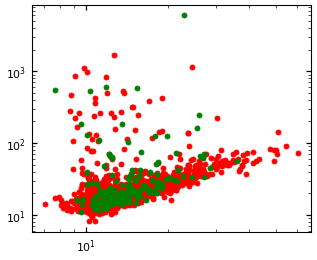

In [95]:
plt.scatter(cuts_cat['r50'][flag], cuts_cat['sersic_rhalf'][flag], color='g', zorder=10)
plt.scatter(cuts_cat['r50'][~flag], cuts_cat['sersic_rhalf'][~flag], color='r', )

plt.xscale('log')
plt.yscale('log')

In [295]:
cuts_cat[flag][cuts_cat['sersic_rhalf'][flag] > 200]['viz-id']

3256
9588
23552
23950
31162
35220
40862
40955
49557
54383
75217


In [91]:
cuts_cat[flag].write('./Catalog/NSA/z002_004/UDG_NSA_MW_z002_004_JG.fits', overwrite=True)